In [1]:
import pandas as pd
df = pd.read_csv('data/dulieu_huanluyen.csv')
# df = df.sample(frac=0.001, random_state=42)
df = df.sample(n=2000, random_state=42)
print(df.info())
print(df[df['comments'].isnull()])

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 70241 to 20131
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  2000 non-null   object
 1   flag      2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 46.9+ KB
None
Empty DataFrame
Columns: [comments, flag]
Index: []


In [2]:
df = df.dropna(subset=['comments'])
df = df.reset_index(drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  2000 non-null   object
 1   flag      2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


In [3]:
from underthesea import word_tokenize
df["comments_segmented"] = df["comments"].apply(lambda x: word_tokenize(x, format="text"))
print(df.head())

/Users/tuankietnguyen/Documents/Learn/ThS/DataMining/Topic/uts-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                                            comments  flag  \
0      Hinh anh va video chi mang tinh chat minh hoa     1   
1  hien tuong nay nam      toi co đoc no trong qu...     2   
2  áo len đẹp lắm lắm ý ạa mình mua có  mấy nghìn...     2   
3                ok vs giá tuền Shop phục vụ rất tốt     2   
4  Vậy mà nói Apple  Sam cũng cạn ý tưởng thiết k...     0   

                                  comments_segmented  
0      Hinh anh va_video chi mang tinh chat_minh hoa  
1  hien tuong nay nam_toi co_đoc no trong quyen s...  
2  áo len_đẹp lắm lắm_ý ạa mình mua có mấy nghìn ...  
3                ok vs giá tuền_Shop phục_vụ rất tốt  
4  Vậy_mà nói Apple_Sam cũng cạn ý_tưởng thiết_kế...  


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

x_train = train_df["comments"].tolist()
x_test = test_df["comments"].tolist()

x_train_segmented = train_df["comments_segmented"].tolist()
x_test_segmented = test_df["comments_segmented"].tolist()

y_train = train_df["flag"].tolist()
y_test = test_df["flag"].tolist()



In [ ]:
from sklearn.naive_bayes import MultinomialNB

tmp = TfidfVectorizer(ngram_range=(1,2))
preproc   = tmp.build_preprocessor() 
tokenizer = tmp.build_tokenizer()   

vec = TfidfVectorizer(
    preprocessor=preproc,
    tokenizer=tokenizer,
    token_pattern=None,
    ngram_range=(1,2),
    min_df=2
)

pipe = Pipeline([
    ('tfidf', vec),
    ('nb',   MultinomialNB())
])

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'nb__alpha':          [0.1, 0.5, 1.0],
    'nb__fit_prior':      [True, False]
}

gs = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1)

gs.fit(x_train_segmented, y_train)
print("Best hyper-parameters:", gs.best_params_)

y_pred_nb = gs.predict(x_test_segmented)
print("=== Naive Bayes ===")
print(classification_report(y_test, y_pred_nb))

Best hyper-parameters: {'nb__alpha': 0.1, 'nb__fit_prior': True, 'tfidf__ngram_range': (1, 2)}
=== Naive Bayes ===
              precision    recall  f1-score   support

           0       0.61      0.62      0.61       139
           1       0.53      0.50      0.51       142
           2       0.62      0.66      0.64       119

    accuracy                           0.59       400
   macro avg       0.59      0.59      0.59       400
weighted avg       0.59      0.59      0.59       400



In [6]:
from sklearn.svm import LinearSVC

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
)

pipe_svm = Pipeline([
    ("tfidf", tfidf),
    ("svm",   LinearSVC(max_iter=10000))
])

param_grid_svm = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "svm__C":            [0.1, 1, 10],
    "svm__class_weight": [None, "balanced"]
}

gs_svm = GridSearchCV(
    pipe_svm,
    param_grid_svm,
    cv=3,
    n_jobs=-1,
    verbose=1
)

gs_svm.fit(x_train_segmented, y_train)

print("Best hyper-parameters (SVM):", gs_svm.best_params_)

y_pred_svm = gs_svm.predict(x_test_segmented)
print(classification_report(y_test, y_pred_svm))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best hyper-parameters (SVM): {'svm__C': 0.1, 'svm__class_weight': 'balanced', 'tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.59      0.62      0.61       139
           1       0.54      0.51      0.52       142
           2       0.64      0.66      0.65       119

    accuracy                           0.59       400
   macro avg       0.59      0.59      0.59       400
weighted avg       0.59      0.59      0.59       400



In [7]:
import os
from datasets import Dataset
from transformers import AutoTokenizer
import py_vncorenlp
import evaluate

train_labels = [label for label in y_train]
test_labels  = [label for label in y_test]

save_directory = os.path.join(os.getcwd(), 'vncorenlp') 
py_vncorenlp.download_model(save_dir=save_directory)
rdrsegmenter = py_vncorenlp.VnCoreNLP(save_dir=save_directory)

def word_segment(sent):
    return ' '.join(rdrsegmenter.word_segment(sent))

x_train_seg = [word_segment(s) for s in x_train]
x_test_seg  = [word_segment(s) for s in x_test]

train_ds = Dataset.from_dict({"text": x_train_seg, "label": train_labels})
test_ds  = Dataset.from_dict({"text": x_test_seg,  "label": test_labels})

MODEL_v2 = "vinai/phobert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_v2)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn,  batched=True)

cols = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=cols)
test_ds.set_format(type="torch",  columns=cols)


VnCoreNLP model folder /Users/tuankietnguyen/Documents/Learn/ThS/DataMining/Topic/vncorenlp already exists! Please load VnCoreNLP from this folder!
2025-06-28 10:46:34 INFO  WordSegmenter:24 - Loading Word Segmentation model
2025-06-28 10:46:34 INFO  PosTagger:23 - Loading POS Tagging model
2025-06-28 10:46:38 INFO  NerRecognizer:34 - Loading NER model
2025-06-28 10:46:46 INFO  DependencyParser:32 - Loading Dependency Parsing model


Map: 100%|██████████| 400/400 [00:00<00:00, 8244.70 examples/s]


In [8]:

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(MODEL_v2, num_labels=3)

accuracy  = evaluate.load("accuracy")
f1        = evaluate.load("f1")
precision = evaluate.load("precision")
recall    = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy":  accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro":  f1.compute(predictions=preds, references=labels, average="macro")["f1"],
        "precision": precision.compute(predictions=preds, references=labels, average="macro")["precision"],
        "recall":    recall.compute(predictions=preds, references=labels, average="macro")["recall"]
    }

training_args = TrainingArguments(
    output_dir="./phobert_sentiment",
    num_train_epochs=2,
    per_device_train_batch_size=4,      
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=200,
    save_steps=5000,
    save_total_limit=1,
    do_train=True,
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

trainer.train()
metrics = trainer.evaluate()
print(metrics)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/tuankietnguyen/Documents/Learn/ThS/DataMining/Topic/uts-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
200,1.012200
400,0.916200
600,0.739400
800,0.656300


/Users/tuankietnguyen/Documents/Learn/ThS/DataMining/Topic/uts-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.9197021722793579, 'eval_accuracy': 0.63, 'eval_f1_macro': 0.6321641321641321, 'eval_precision': 0.6299330415591217, 'eval_recall': 0.6363872329760762, 'eval_runtime': 4.991, 'eval_samples_per_second': 80.144, 'eval_steps_per_second': 10.018, 'epoch': 2.0}


/var/folders/fq/vqgssw4s6ns5szvbhy3dfcgr0000gn/T/ipykernel_75497/3406889273.py:43: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/tuankietnguyen/Documents/Learn/ThS/DataMining/Topic/uts-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


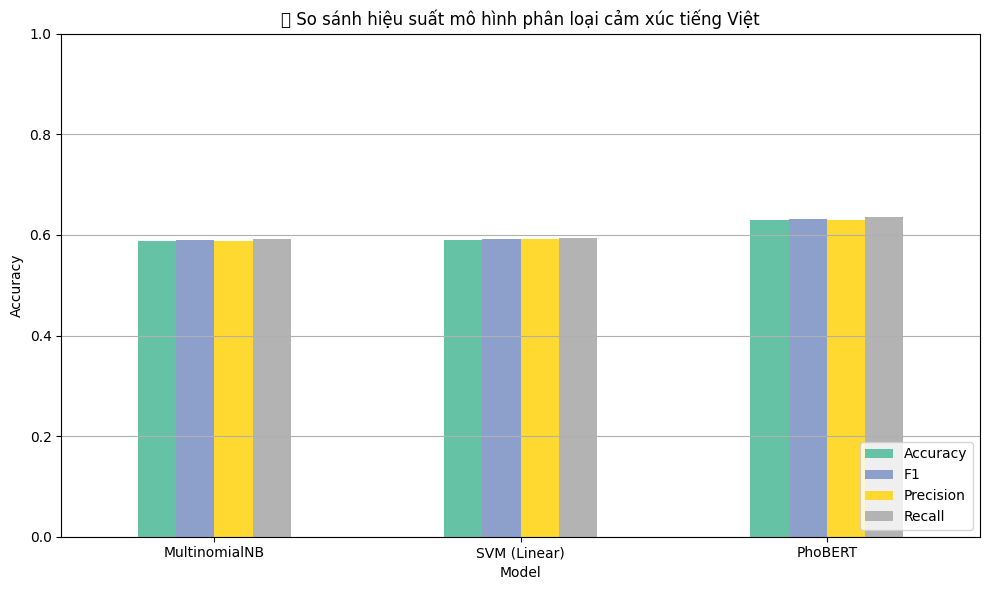

/var/folders/fq/vqgssw4s6ns5szvbhy3dfcgr0000gn/T/ipykernel_75497/3406889273.py:71: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/tuankietnguyen/Documents/Learn/ThS/DataMining/Topic/uts-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


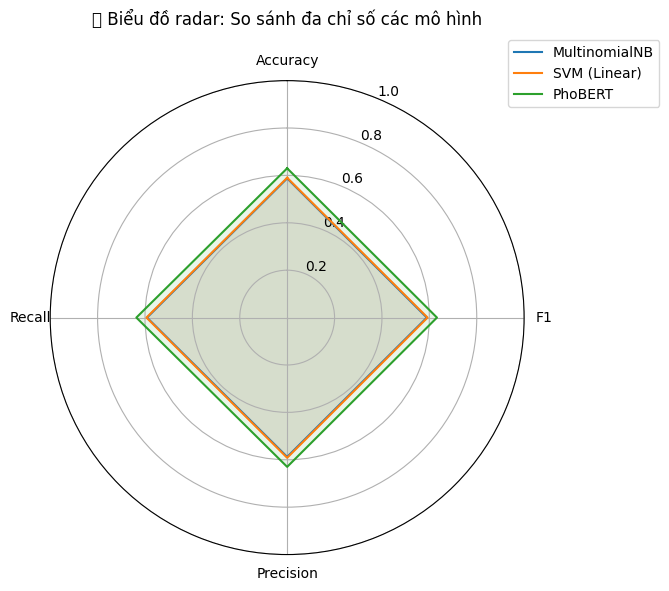

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

nb_metrics = {
    'Model': 'MultinomialNB',
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'F1': f1_score(y_test, y_pred_nb, average='macro'),
    'Precision': precision_score(y_test, y_pred_nb, average='macro'),
    'Recall': recall_score(y_test, y_pred_nb, average='macro'),
}

svm_metrics = {
    'Model': 'SVM (Linear)',
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'F1': f1_score(y_test, y_pred_svm, average='macro'),
    'Precision': precision_score(y_test, y_pred_svm, average='macro'),
    'Recall': recall_score(y_test, y_pred_svm, average='macro'),
}

phobert_metrics = {
    "Model": "PhoBERT",
    "Accuracy": metrics["eval_accuracy"],
    "F1":       metrics["eval_f1_macro"],
    "Precision": metrics["eval_precision"],
    "Recall":    metrics["eval_recall"]
}

df = pd.DataFrame([nb_metrics, svm_metrics, phobert_metrics])
df.set_index("Model", inplace=True)
df = df.dropna(axis=1) 

df.plot(kind="bar", figsize=(10, 6), colormap="Set2", rot=0)
plt.title("📊 So sánh hiệu suất mô hình phân loại cảm xúc tiếng Việt")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.grid(axis="y")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

labels = df.columns
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

for model_name, row in df.iterrows():
    values = row.tolist()
    values += values[:1]  
    ax.plot(angles, values, label=model_name)
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1.0)

plt.title("🌐 Biểu đồ radar: So sánh đa chỉ số các mô hình", y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


In [ ]:
import torch
from transformers import AutoTokenizer

id2label = {0: "NEG", 1: "NEU", 2: "POS"}
label2id = {v: k for k, v in id2label.items()}

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)

def word_segment(raw_text):
    return raw_text 

def predict_sentiment(texts):
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256
    )
    inputs = {k: v.to(trainer.model.device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = trainer.model(**inputs).logits
        preds_pho = torch.argmax(logits, dim=-1).cpu().numpy()
    labels_pho = [id2label[int(i)] for i in preds_pho]

    seg_texts = [word_segment(t) for t in texts]
    labels_svm = [id2label[int(i)] for i in gs_svm.best_estimator_.predict(seg_texts)]
    labels_nb  = [id2label[int(i)] for i in gs.best_estimator_.predict(seg_texts)]

    return {
        "phobert": labels_pho,
        "svm":     labels_svm,
        "nb":      labels_nb
    }


if __name__ == "__main__":
    sample_texts = [
        "Sản phẩm quá tuyệt vời, giao hàng siêu nhanh!",   # POS
        "Hộp hơi móp, nhưng nhìn chung cũng tạm ổn.",      # NEU
        "Chất lượng chán",                                    # NEG
        "Chất lượng tệ"                                    # NEG
    ]
    results = predict_sentiment(sample_texts)
    for model_name, preds in results.items():
        print(f"\n>>> {model_name.upper()}")
        for s, p in zip(sample_texts, preds):
            print(f"• \"{s}\"  →  {p}")



>>> PHOBERT
• "Sản phẩm quá tuyệt vời, giao hàng siêu nhanh!"  →  POS
• "Hộp hơi móp, nhưng nhìn chung cũng tạm ổn."  →  NEU
• "Chất lượng chán"  →  POS
• "Chất lượng tệ"  →  NEG

>>> SVM
• "Sản phẩm quá tuyệt vời, giao hàng siêu nhanh!"  →  POS
• "Hộp hơi móp, nhưng nhìn chung cũng tạm ổn."  →  NEU
• "Chất lượng chán"  →  NEG
• "Chất lượng tệ"  →  NEG

>>> NB
• "Sản phẩm quá tuyệt vời, giao hàng siêu nhanh!"  →  POS
• "Hộp hơi móp, nhưng nhìn chung cũng tạm ổn."  →  NEG
• "Chất lượng chán"  →  NEG
• "Chất lượng tệ"  →  NEG
